## Import the Necessary functions


In [68]:
import pandas as pd
import numpy as np
import json, os
import pprint
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras import regularizers
from keras.models import load_model
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import correlate, correlation_lags
from datetime import datetime
import random
from math import inf
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Add, MultiHeadAttention, Dropout, Conv1D, Bidirectional, GlobalAveragePooling1D
import itertools
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import parallel_backend
import joblib
import matplotlib.pyplot as plt

# Define Constants

In [69]:
SUBSTITUE_VALUE = -1
MAX_CONNECTORS = 10
TIMESTEPS = 144

weather_cols = ['G_0', 'RH']    #[ 'G_0', 'RH', 'T_a']
LABELS = {
    'normal':0,
    'bad_crimp':1,
    'cross_mated':2,
    'unknown':-1
}

# ML model class definition
let's define the class for our ML Molel

In [70]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv1D(filters, kernel_size, padding='same', activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = Conv1D(filters, kernel_size, padding='same', activation=None)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = Conv1D(filters, 1, padding='same')
        self.add = Add()
        self.relu = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # Apply 1x1 convolution to inputs to match the shape
        inputs = self.conv3(inputs)

        x = self.add([x, inputs])
        return self.relu(x)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, sequence_length, d_model):
        angle_rads = self.get_angles(
            position=tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # Apply sin to even indices in the array; 2i
        angle_rads = tf.where(
            tf.range(d_model) % 2 == 0,
            tf.math.sin(angle_rads),
            tf.math.cos(angle_rads)
        )

        pos_encoding = angle_rads[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


class timeseries_ml_model():
  def __init__(self,
               time_steps,
               input_features=48,
               output_variables=10,
               epochs=100,
               batch_size=32,
               save_best_model_during_training=True,
               loss = 'binary_crossentropy',
               metric = 'accuracy',
               optimizer = 'adam',
               last_activation = 'softmax',
               output_size=3,
               dense_neurons = 16
               ):
    self.time_steps = time_steps
    self.input_features = input_features
    self.epochs = epochs
    self.batch_size = batch_size
    self.optimizer = optimizer
    self.last_activation = last_activation
    self.x_train = None
    self.x_test = None
    self.y_train = None
    self.y_test = None
    self.model = None
    self.model_checkpoints = save_best_model_during_training
    self.loss = loss
    self.metric = metric
    self.output_size = output_size
    self.dense_neurons = dense_neurons


  def train_model(self):
    if self.training_dataset is None:
      raise ValueError("Training dataset is not set.")

    callbacks = []
    if self.model_checkpoints:
      filepath = 'Bi-input_ML.keras'
      model_checkpoint_callback = ModelCheckpoint(filepath,
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='min',
                                                  save_freq='epoch',
                                                  initial_value_threshold=None
                                                  )
      callbacks.append(model_checkpoint_callback)
    history = self.model.fit(self.training_dataset, validation_data=self.test_dataset,
                             epochs=self.epochs,
                             callbacks=callbacks)
    return history

  def get_data(self,
               data_1,
               data_2,
               target,
               purpose='train'
               ):
      if purpose == 'train':

        print(type(data_1), type(data_2), type(target), data_1.shape, data_2.shape, target.shape)

        data_1_train, data_1_test, data_2_train, data_2_test, target_train, target_test = train_test_split(data_1, data_2, target, test_size=0.2, random_state=42)

        self.training_dataset = tf.data.Dataset.from_tensor_slices(({'Input_1': data_1_train, 'Input_2': data_2_train}, target_train))
        self.training_dataset = self.training_dataset.shuffle(buffer_size=10000)
        self.training_dataset = self.training_dataset.batch(self.batch_size)
        self.training_dataset = self.training_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        self.test_dataset = tf.data.Dataset.from_tensor_slices(({'Input_1': data_1_test, 'Input_2': data_2_test}, target_test))
        self.test_dataset = self.test_dataset.shuffle(buffer_size=10000)
        self.test_dataset = self.test_dataset.batch(self.batch_size)
        self.test_dataset = self.test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        print("test:", self.training_dataset)

      elif purpose == 'test':
        self.test_dataset = tf.data.Dataset.from_tensor_slices(({'Input_1': data_1, 'Input_2': data_2}, target))
        self.test_dataset = self.test_dataset.batch(1)
        self.test_dataset = self.test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
      else:
        raise ValueError("Purpose must be either 'train' or 'test'.")


  def make_predictions(self):
      return self.model.predict(self.test_data)


  def make_model(self):
      inputs = tf.keras.Input(shape=(self.time_steps, self.input_features), name="Input_1")
      #x = tf.keras.layers.Masking(mask_value=SUBSTITUE_VALUE)(inputs)
      x = tf.keras.layers.Normalization()(inputs)

      x = ResidualBlock(128, 3)(x)
      x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
      x = ResidualBlock(256, 3)(x)
      x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      x = tf.keras.layers.BatchNormalization()(x)

      # Add positional encoding for transformer
      x = PositionalEncoding(self.time_steps // 4, 256)(x)

      attention_output = MultiHeadAttention(num_heads=8, key_dim=256, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.001))(x, x)
      attention_output = Dropout(0.1)(attention_output)
      attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

      ff_output = Dense(256, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.001))(attention_output)
      ff_output = Dropout(0.1)(ff_output)
      ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

      x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.001)))(ff_output)
      x = LayerNormalization()(x)
      x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.001)))(x)
      x = LayerNormalization()(x)

      x = GlobalAveragePooling1D()(x)
      x = tf.keras.layers.Dropout(0.5)(x)

      inputs_2 = tf.keras.Input(shape=(1, MAX_CONNECTORS), name="Input_2")
      y = tf.keras.layers.Masking(mask_value=SUBSTITUE_VALUE)(inputs_2)
      y = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.001))(y)
      outputs = Dense(3, activation=self.last_activation)(y+x)
      #loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=False)
      self.model = tf.keras.Model(inputs=[inputs, inputs_2], outputs=outputs)
      self.model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.0001), loss='mse', metrics=['mean_squared_error', 'mae'])





# Define the helper functions


In [71]:

def calucluate_mean_absolute_error(predictions, actuals):
  # take the absolute difference between the predictions and the labels
  absolute_errors = np.abs(predictions - actuals)
  # calculate the mean absolute error
  mean_absolute_error = np.mean(absolute_errors, axis=0)
  return mean_absolute_error


def get_sensor_data(path, index_column='datetime'):
  data = pd.read_csv(path, index_col=index_column, parse_dates=True)
  date_time = pd.to_datetime(data.index, format='%d.%m.%Y %H:%M:%S')
  day = 24*60*60
  year = (365.2425)*day
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  return data



def fix_lag(all_data, feature1, feature2, lag=None):
  x = all_data[feature1]
  y = all_data[feature2]

  if lag is None:
    correlation = correlate(all_data[feature1], all_data[feature2], mode="full")
    lags = correlation_lags(all_data[feature1].size, all_data[feature2].size, mode="full")
    lag = lags[np.argmax(correlation)]

  if lag < 0:
      x = x.iloc[:lag].reset_index(drop=True)
      x = [np.nan] * abs(lag) + list(x)
  else:
      x = x.iloc[lag:].reset_index(drop=True)
      x = list(x) + [np.nan] * lag
  all_data.loc[:,feature1] = x
  all_data.loc[:,feature2] = y

  return all_data



def get_string_exoskeletons(metadata_path):
  string_1_exoskeltons = []
  string_2_exoskeltons = []

  try:
      with open(metadata_path, 'r') as file:
          metadata = json.load(file)
      print("Metadata file read successfully!")

  except json.JSONDecodeError as err:
      print(f"JSON decode error: {err}")
      print(f"Error at line {err.lineno}, column {err.colno}")
  except Exception as e:
      print(f"An unexpected error occurred: {e}")

  sensor_class = {}
  for sensor, meta in metadata['Sensor_metadata'].items():
    if meta['String_id'] == 'String_1' and meta['sensor_type']=='V_T':
      string_1_exoskeltons.append(sensor)
    elif meta['String_id'] == 'String_2' and meta['sensor_type']=='V_T':
      string_2_exoskeltons.append(sensor)
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_1' and meta['Module_id'] == 'Inverter':
      string_1_inv_sensor = sensor
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_2' and meta['Module_id'] == 'Inverter':
      string_2_inv_sensor = sensor
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_1' and meta['Module_id'] != 'Inverter':
      string_1_current_sensor = sensor
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_2' and meta['Module_id'] != 'Inverter':
      string_2_current_sensor = sensor

    """if meta['sensor_type'] == 'V_T':
      sensor_class[sensor] = metadata['MC4_metadata'][meta['MC4_sample_id']]['label']
    """
  return (string_1_exoskeltons,
          string_2_exoskeltons,
          string_1_inv_sensor,
          string_2_inv_sensor,
          string_1_current_sensor,
          string_2_current_sensor,
          metadata)


def append_shifted_inverter_data(input_data,
                                 inverter_data_path,
                                 index_column='datetime',
                                 cols_of_interest=['U_dc_string1',
                                                   'U_dc_string2',
                                                   'I_dc_string1',
                                                   'I_dc_string2']):
  if inverter_data_path != '':
    inv_data = pd.read_csv(inverter_data_path, index_col=index_column, parse_dates=True)
    inv_data = inv_data[cols_of_interest]
    inv_data.index = pd.to_datetime(inv_data.index)
    input_data = pd.merge(input_data, inv_data, on="datetime", how="inner")

  input_data.index = pd.to_datetime(input_data.index)

  d2 = input_data[(input_data.index<='2024-03-29 23:59:59')]
  d3 = input_data[input_data.index>'2024-03-29 23:59:59']

  d2 = fix_lag(d2, 'I_dc_string1', 'I_FEFFFFB71E5E54E1', 13)
  d3 = fix_lag(d3, 'I_dc_string1', 'I_FEFFFFB71E5E54E1', 1)

  d2 = fix_lag(d2, 'I_dc_string2', 'I_FEFFFFB71E5E54E4', 13)
  d3 = fix_lag(d3, 'I_dc_string2', 'I_FEFFFFB71E5E54E4', 1)

  d2 = fix_lag(d2, 'U_dc_string1', 'I_FEFFFFB71E5E54E1', 13)
  d3 = fix_lag(d3, 'U_dc_string1', 'I_FEFFFFB71E5E54E1', 1)

  d2 = fix_lag(d2, 'U_dc_string2', 'I_FEFFFFB71E5E54E4', 13)
  d3 = fix_lag(d3, 'U_dc_string2', 'I_FEFFFFB71E5E54E4', 1)

  return pd.concat([d2,d3], axis=0)


def filter_data(unfiltered_data,
                s1_exos,
                s2_exos,
                s1_current,
                s2_current):
  V_MAX = 0.03
  I_MAX = 10
  G_MIN = 150
  T_MAX = 35
  R_MAX = 0.003

  filtered_data = unfiltered_data.copy()
  voltage_cols = ["V_"+x for x in s1_exos]+["V_"+x for x in s2_exos]
  current_cols = ["I_"+s1_current, "I_"+s2_current]
  temperature_cols = ["T_"+x for x in s1_exos]+["V_"+x for x in s2_exos]
  resistance_cols = ["R_"+x for x in s1_exos]+["R_"+x for x in s2_exos]

  filtered_data[voltage_cols] = filtered_data[voltage_cols].map(
      lambda x: x if 0 < x <= V_MAX else np.nan)
  filtered_data[current_cols] = filtered_data[current_cols].map(
      lambda x: x if 0 < x <= I_MAX else np.nan)
  filtered_data[temperature_cols] = filtered_data[temperature_cols].map(
      lambda x: x if 0 < x <= T_MAX else np.nan)
  filtered_data[resistance_cols] = filtered_data[resistance_cols].map(
      lambda x: x if 0 < x <= R_MAX else np.nan)

  filtered_data[['G_0']] = filtered_data[['G_0']].map(
      lambda x: x if G_MIN <= x else np.nan)


  return filtered_data

def derive_power_resistance_features( input_data,
                                      _s1_exoskeletons,
                                      _s2_exoskeletons,
                                      _s1_current_sensor,
                                      _s2_current_sensor
                                      ):
  input_data = input_data[(input_data["I_dc_string1"]>0) & (input_data['I_dc_string2']>0)
                          & (input_data["I_"+_s2_current_sensor]>0 ) & (input_data["I_"+_s1_current_sensor]>0)].copy()
  #input_data["V_"+string_1_current_sensor] = input_data[["V_"+x for x in string_1_exoskeltons]].sum(axis=1)
  input_data["P_string1"] = input_data["I_dc_string1"] * input_data["U_dc_string1"]
  input_data["R_string1"] = input_data["U_dc_string1"] / input_data["I_dc_string1"]

  #input_data["V_"+string_2_current_sensor] = input_data[["V_"+x for x in string_2_exoskeltons]].sum(axis=1)
  input_data["P_string2"] = input_data["I_dc_string2"] * input_data["U_dc_string2"]
  input_data["R_string2"] = input_data["U_dc_string2"] / input_data["I_dc_string2"]

  for col in _s1_exoskeletons:
    input_data["P_"+col] = input_data["I_"+_s1_current_sensor] * input_data["V_"+col]
    input_data["R_"+col] = input_data["V_"+col] / input_data["I_"+_s1_current_sensor]

  for col in _s2_exoskeletons:
    input_data["P_"+col] = input_data["I_"+_s2_current_sensor] * input_data["V_"+col]
    input_data["R_"+col] = input_data["V_"+col] / input_data["I_"+_s2_current_sensor]

  # filter the data
  input_data = filter_data(input_data,
                          _s1_exoskeletons,
                          _s2_exoskeletons,
                          _s1_current_sensor,
                          _s2_current_sensor)

  return input_data

def find_missing_days(df):
    missingData = {}
    years = set(df.index.year)
    months = set(df.index.month)
    for year in years:
      missingData[year] = {}
      for month in months:
          absent_days=[]
          try:
            for day in range(min(set(df[(df.index.month==month) & (df.index.year==year)].index.day)),
                            max(set(df[(df.index.month==month) & (df.index.year==year)].index.day))+1):
                if day not in set(df[df.index.month==month].index.day):
                    absent_days.append(day)
          except:
            pass
      missingData[year][month] = absent_days
    return missingData

def prepare_timeseries_data(input_data):
    # calculate all the missing days data
    missingData = find_missing_days(input_data)
    print(missingData)
    # Interpolate at 5 min
    input_data = input_data.resample("5min").interpolate()

    # retain only day time data
    input_data = input_data[(input_data.index.hour>6) & (input_data.index.hour<=18)]
    # remove from the resampled data the days which were not present initially.
    df = input_data.copy()
    for year, missing_days in missingData.items():
      for month, days in missing_days.items():
          for day in days:
              df = df[(df.index.year!=year) | (df.index.month!=month) | (df.index.day!=day)]
    print("New df Len: ",len(df), "Data Len: ",len(input_data))

    # first day and last day might not contain the full day data, so remove them.
    df = df[(df.index.month!=df.index.min().month) | (df.index.day!=df.index.min().day)]
    df = df[(df.index.month!=df.index.max().month) | (df.index.day!=df.index.max().day)]

    return df


def replace_connectors_with_sub_values(input_data, list_of_connectors):
  """
  Parameter:
    input_data: DataFrame, from which the connetors need to be replaced with substiture vales
    list_of_connectors: expects a list of int values in range (0, max_connectors - 1)

  Returns:
    Dataframe, with specified columns replaced with specified subustitute value
  """
  for conn in list_of_connectors:
    conn_cols = [["V_"+x, "T_"+x, "P_"+x, "R_"+x] for x in [conn]]
    for conn in conn_cols[0]:
      if conn in input_data.columns:
        input_data.loc[:,conn] = SUBSTITUE_VALUE
      else:
        print(conn, " not present in input_data.")
        input_data[conn] = SUBSTITUE_VALUE
  return input_data


def drop_connectors(input_data, connectors_to_remove):
  """
  This selects a connetor to be dropped from the input_data and appends the
  new input_data to the current its data at the end

  Parameter:
    Data: DataFrame, from which the connetors need to be replaced with substiture vales
    connectors_to_remove: A list of connectors to be removed, where each element is str(connector_number)
  Returns:
    Dataframe, with possible combinations of missing connector appended on the end
  """
  _all_data = input_data.copy()
  for connector_number in sorted(connectors_to_remove, reverse=True):
    input_data = replace_connectors_with_sub_values(input_data, connector_number)
    num_days = len(input_data.resample('1D').mean())
    offset = pd.DateOffset(days=num_days)
    input_data.index = input_data.index + offset

    _all_data = pd.concat([_all_data, input_data], axis=0)

  return _all_data

def fill_substitute(input_data):
  conn_cols = [["V_"+str(x), "T_"+str(x), "P_"+str(x), "R_"+str(x)] for x in range(MAX_CONNECTORS)]
  conn_to_drop = []
  for conn in np.array(conn_cols).flatten():
    if conn not in input_data.columns:
      input_data.loc[:,conn] = SUBSTITUE_VALUE
    else:
      conn_to_drop.append(conn.split('_')[1])

  _all_data = drop_connectors(input_data, set(conn_to_drop))

  return _all_data

def get_string_data(input_data, _s1_exoskeletons, _s2_exoskeletons):
  s1_vt_cols = [("V_"+x, "T_"+x, "P_"+x, "R_"+x) for x in _s1_exoskeletons]
  inv_cols = ["I_dc_", "U_dc_", "P_", "R_"]
  master_cols = (['Day sin'] +
                weather_cols +
                [x+"string1" for x in inv_cols] +
                [x for vt in s1_vt_cols for x in vt])

  string1_data = input_data[master_cols]
  print(len(string1_data))
  #string1_data = string1_data[np.isfinite(string1_data).all(1)]

  s2_vt_cols = [("V_"+x, "T_"+x, "P_"+x, "R_"+x) for x in _s2_exoskeletons]
  master_cols = (['Day sin'] +
                  weather_cols +
                  [x+"string2" for x in inv_cols] +
                  [x for VT in s2_vt_cols for x in VT])
  string2_data = input_data[master_cols]
  print(len(string2_data))
  #string2_data = string2_data[np.isfinite(string2_data).all(1)]

  new_s1_cols = []
  new_s2_cols = []
  for i, x in enumerate([x for VT in s1_vt_cols for x in VT]):
    new_s1_cols.append(x[:2]+str(int(i/4)))
  new_s1_cols = ['Day sin'] + weather_cols + ["I_S", "V_S", "P_S", "R_S"] + new_s1_cols
  for i, x in enumerate([x for VT in s2_vt_cols for x in VT]):
    new_s2_cols.append(x[:2]+str(int(i/4)))
  new_s2_cols = ['Day sin'] + weather_cols + ["I_S", "V_S", "P_S", "R_S"] + new_s2_cols

  if len(new_s1_cols) > len(new_s2_cols):
    final_cols = new_s1_cols
  else:
    final_cols = new_s2_cols
  column_mapping_s1 = {}
  column_mapping_s2 = {}
  for col1, col2, col3 in itertools.zip_longest(string1_data.columns, string2_data.columns, final_cols, fillvalue=None):
    if col1 is not None:
        column_mapping_s1[col1] = col3
    if col2 is not None:
        column_mapping_s2[col2] = col3

  string1_data.columns = new_s1_cols
  string2_data.columns = new_s2_cols

  return string1_data, string2_data, column_mapping_s1, column_mapping_s2


def drop_x_percent_data(input_data, percent, non_substituted_cols, num_permutation, max_connectors, num_days):
  offset = pd.DateOffset(days=num_days)
  input_data.index = input_data.index + offset
  if percent==0:
    return input_data, num_days+len(input_data.resample('1D').mean())

  num_conn_to_drop = int(max_connectors*percent/100)
  _all_data = pd.DataFrame()
  prev_choice = None
  for p in range(num_permutation):
    indices = np.random.choice(max_connectors, num_conn_to_drop, replace=False)
    while (prev_choice==indices).all():
      indices = np.random.choice(max_connectors, num_conn_to_drop, replace=False)

    connectors_to_remove = [non_substituted_cols[i] for i in indices]
    temp_data = replace_connectors_with_sub_values(input_data, connectors_to_remove)
    if len(_all_data)>0:
      num_days = len(_all_data.resample('1D').mean())
      offset = pd.DateOffset(days=num_days)
      temp_data.index = temp_data.index + offset
    _all_data = pd.concat([_all_data, temp_data], axis=0)
    prev_choice = indices

  next_lot_index_starts_after = num_days+len(_all_data.resample('1D').mean())
  return _all_data, next_lot_index_starts_after, connectors_to_remove

def IQR_outliers_filter(input_data, cols):
  for col in cols:
    Q1 = input_data[col].quantile(0.25)
    Q3 = input_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = [x for x in input_data[col] if x < lower_bound or x > upper_bound]
    print(f"IQR outliers in {col}: {outliers}")
    input_data[col] = np.where((input_data[col] < lower_bound) | (input_data[col] > upper_bound), np.nan, input_data[col])
    input_data[col] = input_data[col].interpolate(method="polynomial", order=2)
  return input_data


In [72]:
def get_label_from_phase1(exos, old_new_col_map, rm_conns, meta, data, model):
  """
  This funciton take list of all exoskeletons, test_data, meta of all exoskeletons and the model
  and returns the actual and predicted labels.
  It is assumed that the the X_test contains the label as well and it is in its last column.
  """
  labels = []
  for exo in exos:
    exo_id = old_new_col_map["V_"+exo].split('_')[1]
    cols = ["V_"+exo_id, "T_"+exo_id, "P_"+exo_id, "R_"+exo_id, "G_0", "RH"]
    if exo_id not in rm_conns:
      result = pd.DataFrame(model.predict(data[cols])).value_counts()
      labels.append(result.idxmax()[0])
    else:
      labels.append(LABELS['unknown'])
  while(len(labels)<MAX_CONNECTORS):
    labels.append(LABELS['unknown'])
  print("test", labels)
  return labels

def get_label(exos, old_new_col_map, rm_conns, meta):
  global LABELS
  label1 = []
  for col in exos:
    new_id = old_new_col_map["V_"+col].split('_')[1]
    if new_id not in rm_conns:
      id = meta["Sensor_metadata"][col]["MC4_sample_id"]
      label = LABELS[meta["MC4_metadata"][id]["label"]]
      label1.append(label)
    else:
      label1.append(LABELS['unknown'])
  while(len(label1)<MAX_CONNECTORS):
    label1.append(LABELS['unknown'])
  return label1

def prepare_data(batch_data,
                 s1_exo, s2_exo,
                 s1_composition, s2_composition,
                 meta_data,
                 model):
  print("Preparing data for batch: ", batch_data)
  b1_data1, b1_data2, d1_map, d2_map = get_string_data(batch_data, s1_exo, s2_exo)
  print(len(b1_data1), len(b1_data2))
  b1_data1 = prepare_timeseries_data(b1_data1)
  b1_data2 = prepare_timeseries_data(b1_data2)

  data1 = b1_data1.copy()
  data2 = b1_data2.copy()

  non_substituted_cols = [str(x) for x in range(MAX_CONNECTORS)]
  num_days = len(data1.resample('1D').mean())
  s1_00_percent_data_b1, num_days_00, rm_conns1  = drop_x_percent_data(data1.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
  s1_20_percent_data_b1, num_days_20, rm_conns2  = drop_x_percent_data(data1.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
  s1_40_percent_data_b1, num_days_40, rm_conns3  = drop_x_percent_data(data1.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
  s1_60_percent_data_b1, num_days_60, rm_conns4  = drop_x_percent_data(data1.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
  s1_80_percent_data_b1, num_days_80, rm_conns5  = drop_x_percent_data(data1.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
  s1_100_percent_data_b1, num_days_100  = drop_x_percent_data(data1.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)

  s1_data = pd.concat([s1_00_percent_data_b1, s1_20_percent_data_b1, s1_40_percent_data_b1, s1_60_percent_data_b1, s1_80_percent_data_b1, s1_100_percent_data_b1], axis=0)
  #s1_data = s1_100_percent_data_b1.copy()

  label_00 = get_label_from_phase1(s1_exo, d1_map, rm_conns1, meta_data, data1.copy(), model)
  label_20 = get_label_from_phase1(s1_exo, d1_map, rm_conns2, meta_data, data1.copy(), model)
  label_40 = get_label_from_phase1(s1_exo, d1_map, rm_conns3, meta_data, data1.copy(), model)
  label_60 = get_label_from_phase1(s1_exo, d1_map, rm_conns4, meta_data, data1.copy(), model)
  label_80 = get_label_from_phase1(s1_exo, d1_map, rm_conns5, meta_data, data1.copy(), model)
  label_100 = get_label_from_phase1(s1_exo, d1_map, [], meta_data, data1.copy(), model)
  s1_input_2 = [[label_00]*int(len(s1_00_percent_data_b1)/TIMESTEPS),
             [label_20]*int(len(s1_20_percent_data_b1)/TIMESTEPS),
             [label_40]*int(len(s1_40_percent_data_b1)/TIMESTEPS),
             [label_60]*int(len(s1_60_percent_data_b1)/TIMESTEPS),
             [label_80]*int(len(s1_80_percent_data_b1)/TIMESTEPS),
             [label_100]*int(len(s1_100_percent_data_b1)/TIMESTEPS)]
  #s1_input_2 = [[label_100]*int(len(s1_100_percent_data_b1)/TIMESTEPS)]
  s1_input_2 = [np.array(x) for x in s1_input_2]

  # Concatenate all arrays along the first axis
  s1_input_2 = np.concatenate(s1_input_2, axis=0)

  num_days = len(data2.resample('1D').mean())
  s2_00_percent_data_b1, num_days_00, rm_conns1  = drop_x_percent_data(data2.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
  s2_20_percent_data_b1, num_days_20, rm_conns2  = drop_x_percent_data(data2.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
  s2_40_percent_data_b1, num_days_40, rm_conns3  = drop_x_percent_data(data2.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
  s2_60_percent_data_b1, num_days_60, rm_conns4  = drop_x_percent_data(data2.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
  s2_80_percent_data_b1, num_days_80, rm_conns5  = drop_x_percent_data(data2.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
  s2_100_percent_data_b1, num_days_100  = drop_x_percent_data(data2.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)


  s2_data = pd.concat([s2_00_percent_data_b1, s2_20_percent_data_b1, s2_40_percent_data_b1, s2_60_percent_data_b1, s2_80_percent_data_b1, s2_100_percent_data_b1], axis=0)
  #s2_data = s2_100_percent_data_b1.copy()
  label_00 = get_label_from_phase1(s2_exo, d2_map, rm_conns1, meta_data, data2.copy(), model)
  label_20 = get_label_from_phase1(s2_exo, d2_map, rm_conns2, meta_data, data2.copy(), model)
  label_40 = get_label_from_phase1(s2_exo, d2_map, rm_conns3, meta_data, data2.copy(), model)
  label_60 = get_label_from_phase1(s2_exo, d2_map, rm_conns4, meta_data, data2.copy(), model)
  label_80 = get_label_from_phase1(s2_exo, d2_map, rm_conns5, meta_data, data2.copy(), model)
  label_100 = get_label_from_phase1(s2_exo, d2_map, [], meta_data, data2.copy(), model)
  s2_input_2 = [[label_00]*int(len(s2_00_percent_data_b1)/TIMESTEPS),
             [label_20]*int(len(s2_20_percent_data_b1)/TIMESTEPS),
             [label_40]*int(len(s2_40_percent_data_b1)/TIMESTEPS),
             [label_60]*int(len(s2_60_percent_data_b1)/TIMESTEPS),
             [label_80]*int(len(s2_80_percent_data_b1)/TIMESTEPS),
             [label_100]*int(len(s2_100_percent_data_b1)/TIMESTEPS)]
  #s2_input_2 = [[label_100]*int(len(s2_100_percent_data_b1)/TIMESTEPS)]
  s2_input_2 = [np.array(x) for x in s2_input_2]

  # Concatenate all arrays along the first axis
  s2_input_2 = np.concatenate(s2_input_2, axis=0)

  num_days = len(data1.resample('1D').mean())
  offset = pd.DateOffset(days=num_days)
  data2.index = data2.index + offset
  print(len(s1_data), len(s2_data))
  X_batch1 = pd.concat([s1_data, s2_data], axis=0)
  X2_batch1 = np.concatenate((s1_input_2, s2_input_2), axis=0)

  num_of_trainable_instances_df1 = int(len(s1_data)/TIMESTEPS)
  num_of_trainable_instances_df2 = int(len(s2_data)/TIMESTEPS)

  target_batch1 = np.array([s1_composition]*num_of_trainable_instances_df1 + [s2_composition]*num_of_trainable_instances_df2)

  return X_batch1, X2_batch1, target_batch1

In [73]:

def prepare_phase1_data(_data,_s1_exo, _s2_exo,_s1_current, _s2_current, _meta):
  """
    This function prepares the data for phase-1 model, including removal of outliers using IQR(1.5) I.e., prepare the I, V, P, R, G and RH features for each connector.
    we will be able to predict the class of the connector.

    Parameters:
      _data: A dataframe that contains the sensor data of each sensor.
      _s1_exo: A list of string-1 exoskeletons.
      _s2_exo: A list of string-2 exoskeletons.
      _s1_current: string-1 current sensor.
      _s2_current: string-2 current sensor.
      _meta: A dictionary that contains the metadata of each sensor.

    Returns:
      A dataframe that contains the I, V, P, R, G and RH features for each connector along with the label.
  """
  full_data = pd.DataFrame()
  all_exo = _s1_exo + _s2_exo
  for exo in all_exo:
    cols = ["V_"+exo, "T_"+exo, "P_"+exo, "R_"+exo, "G_0", "RH"]
    temp_data = _data[cols]
    temp_data.columns = ["V", "T", "P", "R", "G", "RH"]

    #filter outliers
    Q1 = temp_data.quantile(0.25)
    Q3 = temp_data.quantile(0.75)
    IQR = Q3 - Q1
    temp_data = temp_data[~((temp_data < (Q1 - 1.5 * IQR)) |(temp_data > (Q3 + 1.5 * IQR))).any(axis=1)]

    id = _meta['Sensor_metadata'][exo]['MC4_sample_id']
    label = _meta['MC4_metadata'][id]['label']
    temp_data = temp_data.assign(name=exo)
    temp_data = temp_data.assign(label=LABELS[label])

    full_data = pd.concat([full_data, temp_data], axis=0)

  return full_data

# Get the University o Bern Data

Now, we can load sensor data and get meta information about the sensors.

After this is done, we need to shift the inverter data (there is a shift of 1 hour 5 mins in March data, and 5 min shift afterwards). Then data will be combined and P and R will be derived for each exoskeleton

In [74]:
bern_data = get_sensor_data("./content/ShiftFixed_data.csv")
(s1_exoskeletons_b1,
 s2_exoskeletons_b1,
 s1_inv_sensor_b1,
 s2_inv_sensor_b1,
 s1_current_sensor_b1,
 s2_current_sensor_b1,
 metadata_b1
 ) = get_string_exoskeletons("./content/metadata_bfh.json")

(s1_exoskeletons_b2,
 s2_exoskeletons_b2,
 s1_inv_sensor_b2,
 s2_inv_sensor_b2,
 s1_current_sensor_b2,
 s2_current_sensor_b2,
 metadata_b2
 ) = get_string_exoskeletons("./content/metadata_bfh_Exp2.json")

(s1_exoskeletons_b3,
 s2_exoskeletons_b3,
 s1_inv_sensor_b3,
 s2_inv_sensor_b3,
 s1_current_sensor_b3,
 s2_current_sensor_b3,
 metadata_b3
 ) = get_string_exoskeletons("./content/metadata_bfh_Exp3.json")

(s1_exoskeletons_b4,
 s2_exoskeletons_b4,
 s1_inv_sensor_b4,
 s2_inv_sensor_b4,
 s1_current_sensor_b4,
 s2_current_sensor_b4,
 metadata_b4
 ) = get_string_exoskeletons("./content/metadata_bfh_Exp4.json")

(s1_exoskeletons_b5,
 s2_exoskeletons_b5,
 s1_inv_sensor_b5,
 s2_inv_sensor_b5,
 s1_current_sensor_b5,
 s2_current_sensor_b5,
 metadata_b5
 ) = get_string_exoskeletons("./content/metadata_bfh_Exp5.json")


inv_adjusted_data = bern_data #append_shifted_inverter_data(bern_data, inverter_data_path="")



Metadata file read successfully!
Metadata file read successfully!
Metadata file read successfully!
Metadata file read successfully!
Metadata file read successfully!


In [75]:
inv_adjusted_data.drop(columns=['V_FEFFFFB71E5E54C4', 'T_FEFFFFB71E5E54C4'], inplace=True)
s1_exoskeletons_b1.remove('FEFFFFB71E5E54C4')
s1_exoskeletons_b2.remove('FEFFFFB71E5E54C4')
s1_exoskeletons_b3.remove('FEFFFFB71E5E54C4')

In [76]:
b1_end_date = '2024-04-29 00:00:00'
b2_end_date = '2024-05-21 00:00:00'
b3_end_date = '2024-07-10 00:00:00'
b4_end_date = '2024-07-29 00:00:00'

In [77]:
batch1_data = derive_power_resistance_features(
                  inv_adjusted_data[inv_adjusted_data.index<b1_end_date],
                  s1_exoskeletons_b1,
                  s2_exoskeletons_b1,
                  s1_current_sensor_b1,
                  s2_current_sensor_b1)

batch2_data = derive_power_resistance_features(
                  inv_adjusted_data[(inv_adjusted_data.index > b1_end_date) &
                                    (inv_adjusted_data.index < b2_end_date)],
                  s1_exoskeletons_b2,
                  s2_exoskeletons_b2,
                  s1_current_sensor_b2,
                  s2_current_sensor_b2)

batch3_data = derive_power_resistance_features(
                  inv_adjusted_data[(inv_adjusted_data.index > b2_end_date) &
                                    (inv_adjusted_data.index < b3_end_date)],
                  s1_exoskeletons_b3,
                  s2_exoskeletons_b3,
                  s1_current_sensor_b3,
                  s2_current_sensor_b3)

batch4_data = derive_power_resistance_features(
                  inv_adjusted_data[(inv_adjusted_data.index > b3_end_date) &
                                    (inv_adjusted_data.index < b4_end_date)],
                  s1_exoskeletons_b4,
                  s2_exoskeletons_b4,
                  s1_current_sensor_b4,
                  s2_current_sensor_b4)


batch5_data = derive_power_resistance_features(
                  inv_adjusted_data[(inv_adjusted_data.index > b4_end_date)],
                  s1_exoskeletons_b5,
                  s2_exoskeletons_b5,
                  s1_current_sensor_b5,
                  s2_current_sensor_b5)

## Separate String-1 and String-2 data


Prepare for merging String-1 and String-2 on axis-0

In [78]:
if os.path.exists("./content/best_model.joblib"):
  xgb_model = joblib.load('./content/best_model.joblib')
  X_batch1, X2_batch1, target_batch1 = prepare_data(batch1_data,
                                                    s1_exoskeletons_b1,
                                                    s2_exoskeletons_b1,
                                                    [1., 0., 0.],
                                                    [0.7, 0.15, 0.15],
                                                    metadata_b1,
                                                    xgb_model)
  X_batch2, X2_batch2, target_batch2 = prepare_data(batch2_data,
                                                    s1_exoskeletons_b2,
                                                    s2_exoskeletons_b2,
                                                    [0.85, 0.15, 0.],
                                                    [0.85, 0., 0.15],
                                                    metadata_b2,
                                                    xgb_model)
  X_batch3, X2_batch3, target_batch3 = prepare_data(batch3_data,
                                                    s1_exoskeletons_b3,
                                                    s2_exoskeletons_b3,
                                                    [0.85, 0.09, 0.06],
                                                    [0.85, 0.06, 0.09],
                                                    metadata_b3,
                                                    xgb_model)
  X_batch4, X2_batch4, target_batch4 = prepare_data(batch4_data,
                                                    s1_exoskeletons_b4,
                                                    s2_exoskeletons_b4,
                                                    [0.94, 0.3, 0.3],
                                                    [0.76, 0.12, 0.12],
                                                    metadata_b4,
                                                    xgb_model)
  X_batch5, X2_batch5, target_batch5 = prepare_data(batch5_data,
                                                    s1_exoskeletons_b5,
                                                    s2_exoskeletons_b5,
                                                    [0.7, 0.3, 0.0],
                                                    [0.7, 0.0, 0.3],
                                                    metadata_b5,
                                                    xgb_model)
else:
  print("Please train the XGB model first and save the best model as best_model.joblib")


Preparing data for batch:                       I_FEFFFFB71E5E54E1  I_FEFFFFB71E5E54E3  \
datetime                                                      
2024-03-08 06:55:00              0.3525              0.3510   
2024-03-08 07:00:00              0.4035              0.4035   
2024-03-08 07:05:00              0.3885              0.3885   
2024-03-08 07:10:00              0.3675              0.3675   
2024-03-08 07:15:00              0.4155              0.4140   
...                                 ...                 ...   
2024-04-26 09:10:00              3.3180              3.3120   
2024-04-26 09:15:00              2.9505              2.9430   
2024-04-26 09:20:00              2.2950              2.2890   
2024-04-26 09:25:00              2.0460              2.0430   
2024-04-26 09:30:00              1.7880              1.7865   

                     I_FEFFFFB71E5E54E4  I_FEFFFFB71E5E54E5  \
datetime                                                      
2024-03-08 06:55:00        

#Get the New Delhi Testsite Data

In [79]:
len_wrt_timestep = lambda df: int(len(df)/TIMESTEPS)

In [80]:
s1 = get_sensor_data("./content/pureStr1_Batch3_2022_TSDel.csv", index_column='Time')
s1.loc[:,'C_P'] = s1['C_I']*s1['C_V']
s1.loc[:,'C_P_C2'] = s1['C_I_C2']*s1['C_V_C2']
s1.loc[:,'C_P_C3'] = s1['C_I_C3']*s1['C_V_C3']
doi_s1_testsite = s1[['Day sin', 'W_G', 'S1_C', 'S1_V', 'S1_P', 'S1_R',
                      'C_V', 'C_Tsur',  'C_P', 'C_R',
                      'C_V_C2', 'C_Tsur_C2', 'C_P_C2',  'C_R_C2',
                      'C_V_C3', 'C_Tsur_C3', 'C_P_C3', 'C_R_C3']]
doi_s1_testsite.columns = ['Day sin', 'G_0', 'I_S', 'V_S', 'P_S', 'R_S',
                           'V_0', 'T_0',  'P_0', 'R_0',
                           'V_1', 'T_1',  'P_1', 'R_1',
                           'V_2', 'T_2',  'P_2', 'R_2', ]

num_days = len(doi_s1_testsite.resample("1D").mean())
offset = pd.DateOffset(days=num_days)

s2 = get_sensor_data("./content/pureStr2_Batch3_2022_TSDel.csv", index_column='Time')
s2.loc[:,'C_P'] = s2['C_I']*s2['C_V']
s2.loc[:,'C_P_C2'] = s2['C_I_C2']*s2['C_V_C2']
s2.loc[:,'C_P_C3'] = s2['C_I_C3']*s2['C_V_C3']
doi_s2_testsite = s2[['Day sin', 'W_G', 'S2_C', 'S2_V', 'S2_P', 'S2_R',
                      'C_V', 'C_Tsur',  'C_P', 'C_R',
                      'C_V_C2', 'C_Tsur_C2', 'C_P_C2',  'C_R_C2',
                      'C_V_C3', 'C_Tsur_C3', 'C_P_C3', 'C_R_C3']]
doi_s2_testsite.columns = ['Day sin', 'G_0', 'I_S', 'V_S', 'P_S', 'R_S',
                           'V_0', 'T_0',  'P_0', 'R_0',
                           'V_1', 'T_1',  'P_1', 'R_1',
                           'V_2', 'T_2',  'P_2', 'R_2', ]

doi_s1_testsite[['V_0', 'V_1', 'V_2']] = doi_s1_testsite[['V_0', 'V_1', 'V_2']]/1000
doi_s2_testsite[['V_0', 'V_1', 'V_2']] = doi_s2_testsite[['V_0', 'V_1', 'V_2']]/1000

doi_s1_testsite[['R_0', 'R_1', 'R_2']] = doi_s1_testsite[['R_0', 'R_1', 'R_2']]/1000
doi_s2_testsite[['R_0', 'R_1', 'R_2']] = doi_s2_testsite[['R_0', 'R_1', 'R_2']]/1000


doi_s2_testsite.index += offset

doi_s1_testsite = doi_s1_testsite[doi_s1_testsite['R_S']!=inf]
doi_s1_testsite = prepare_timeseries_data(doi_s1_testsite)
doi_s2_testsite = doi_s2_testsite[doi_s2_testsite['R_S']!=inf]
doi_s2_testsite = prepare_timeseries_data(doi_s2_testsite)


doi_s1_testsite = fill_substitute(doi_s1_testsite)
doi_s2_testsite = fill_substitute(doi_s2_testsite)

X_testsite = pd.concat([doi_s1_testsite, doi_s2_testsite], axis=0)

s1_y_testsite_len_wrt_timesteps = len_wrt_timestep(doi_s1_testsite)
s2_y_testsite_len_wrt_timesteps = len_wrt_timestep(doi_s2_testsite)

testsite_y = np.array([[0.50, 0., 0.50]]*s1_y_testsite_len_wrt_timesteps+[[0.165, 0.335, 0.50]]*s2_y_testsite_len_wrt_timesteps)

X_testsite.head()

{2022: {12: [2, 3, 6, 7, 11, 12, 13, 14]}}


C:\Users\Jkau\AppData\Local\Temp\ipykernel_11704\2110173322.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doi_s1_testsite[['V_0', 'V_1', 'V_2']] = doi_s1_testsite[['V_0', 'V_1', 'V_2']]/1000
C:\Users\Jkau\AppData\Local\Temp\ipykernel_11704\2110173322.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doi_s2_testsite[['V_0', 'V_1', 'V_2']] = doi_s2_testsite[['V_0', 'V_1', 'V_2']]/1000
C:\Users\Jkau\AppData\Local\Temp\ipykernel_11704\2110173322.py:33: SettingWithCopyWarning: 
A value is trying to be 

New df Len:  12846 Data Len:  13998
{2022: {12: [23, 30]}, 2023: {12: []}}
New df Len:  5333 Data Len:  5621


,Day sin,G_0,I_S,V_S,P_S,R_S,V_0,T_0,P_0,R_0,...,P_7,R_7,V_8,T_8,P_8,R_8,V_9,T_9,P_9,R_9
Time,,,,,,,,,,,,,,,,,,,,,
2022-09-10 07:00:00,0.566813,313.909216,4.010784,184.835294,741.725490,46.087632,0.003,36.431373,12.591324,0.000715,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2022-09-10 07:05:00,0.574561,314.038456,4.010294,184.838235,741.647059,46.093876,0.003,36.411765,12.588309,0.000715,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2022-09-10 07:10:00,0.582310,314.167696,4.009804,184.841176,741.568627,46.100120,0.003,36.392157,12.585294,0.000715,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2022-09-10 07:15:00,0.590058,314.296936,4.009314,184.844118,741.490196,46.106364,0.003,36.372549,12.582279,0.000716,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2022-09-10 07:20:00,0.597807,314.426176,4.008824,184.847059,741.411765,46.112608,0.003,36.352941,12.579265,0.000716,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


# Create and Train the time series model

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> (5764, 144, 47) (5764, 1, 10) (5764, 3)
test: <_PrefetchDataset element_spec=({'Input_1': TensorSpec(shape=(None, 144, 47), dtype=tf.float64, name=None), 'Input_2': TensorSpec(shape=(None, 1, 10), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>
Epoch 1/25


C:\Users\Jkau\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Input_1', 'Input_2']. Received: the structure of inputs={'Input_1': '*', 'Input_2': '*'}
  warnings.warn(


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 226ms/step - loss: 356.1487 - mae: 0.1185 - mean_squared_error: 0.0279 - val_loss: 223.7545 - val_mae: 0.0983 - val_mean_squared_error: 0.0163
Epoch 2/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - loss: 196.8787 - mae: 0.1037 - mean_squared_error: 0.0188 - val_loss: 128.0066 - val_mae: 0.0956 - val_mean_squared_error: 0.0157
Epoch 3/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - loss: 111.7773 - mae: 0.1026 - mean_squared_error: 0.0182 - val_loss: 72.4345 - val_mae: 0.0964 - val_mean_squared_error: 0.0153
Epoch 4/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - loss: 62.2631 - mae: 0.1012 - mean_squared_error: 0.0178 - val_loss: 35.5594 - val_mae: 0.0763 - val_mean_squared_error: 0.0098
Epoch 5/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - loss: 28.8985 - mae: 0.1045 - mean_squared_error: 0.0192 - val_loss: 12.6812 - val_mae: 0.1124 - val_mean_squared_error: 0.0222
Epoch 6/25
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - loss: 9.3794 - mae: 0.11

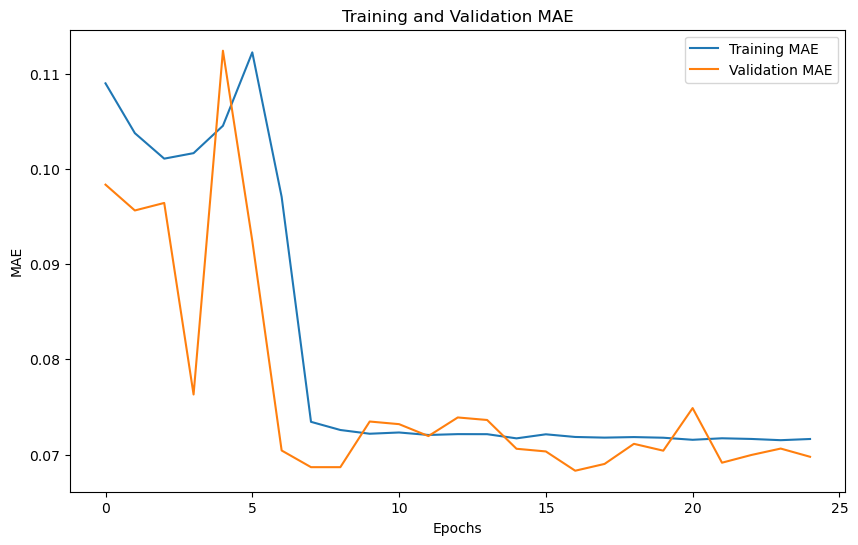

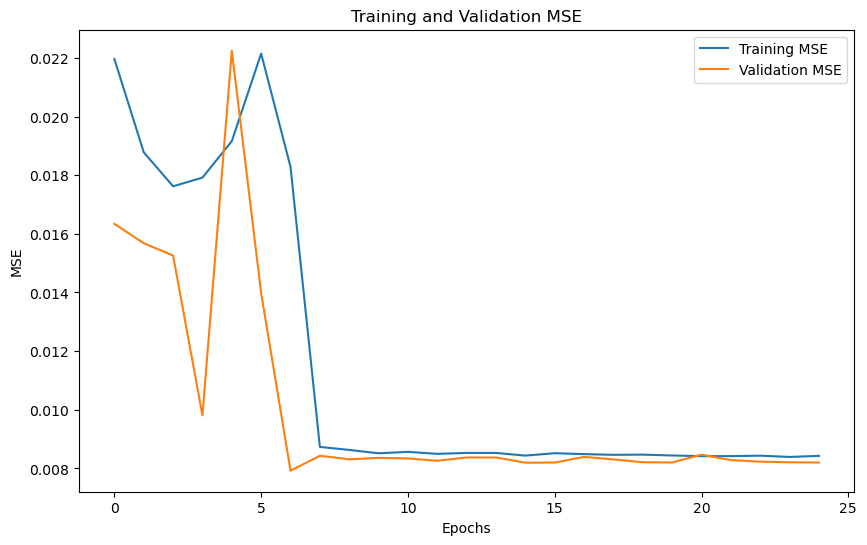

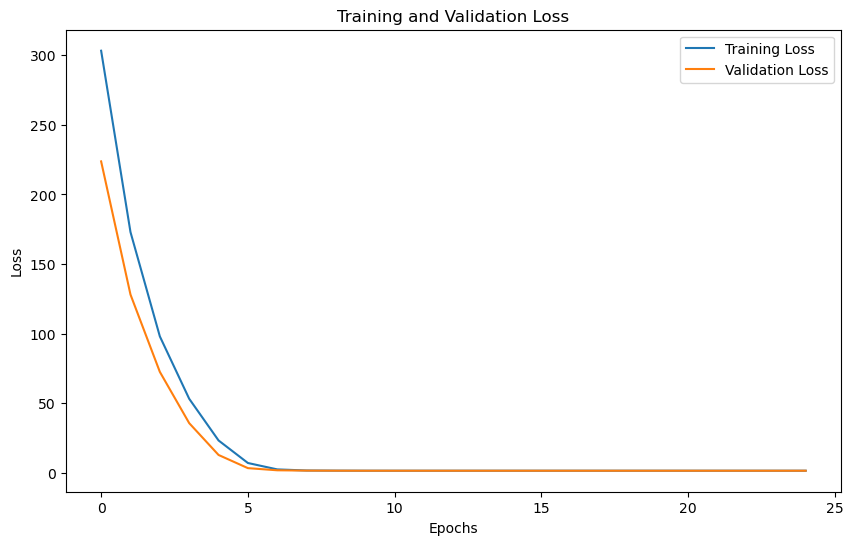

In [81]:
final_dataset_X = pd.concat([X_batch1, X_batch2, X_batch3, X_batch5], axis=0)
final_dataset_x2 = np.concatenate((X2_batch1, X2_batch2, X2_batch3, X2_batch5), axis=0)
final_dataset_y = np.concatenate((target_batch1, target_batch2, target_batch3, target_batch5), axis=0)

final_dataset_X.fillna(SUBSTITUE_VALUE, inplace=True)

num_of_trainable_instances = int(len(final_dataset_X)/TIMESTEPS)
features = len(final_dataset_X.columns)
#scaler = StandardScaler()
data1 = (np.array(final_dataset_X)).reshape(num_of_trainable_instances, TIMESTEPS, features)
data2 = final_dataset_x2.reshape(final_dataset_x2.shape[0], 1, 10)
ai_model = timeseries_ml_model(time_steps= TIMESTEPS, input_features=features, epochs=25, save_best_model_during_training=True)
ai_model.get_data(data1, data2, final_dataset_y, 'train')

ai_model.make_model()
history = ai_model.train_model()
print("test",type(history), history.history)


plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plot the training and validation MSE
plt.figure(figsize=(10, 6))

plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Testing Bern Batch-3 Data
we will load the data of batch-3 from Bern. Here the String Configuration is as follows:


1.   String-1

*   5 Normal
*   3 Bad Crimp
*   2 Crossmated


2.   String-2
*   5 Normal
*   2 Bad Crimp
*   3 Crossmated







24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1.3761 - mae: 0.1560 - mean_squared_error: 0.0293
Evaluation Loss:  1.3659366369247437 Evaluation mae 0.01911028102040291 Evaluation mse 0.11538141220808029


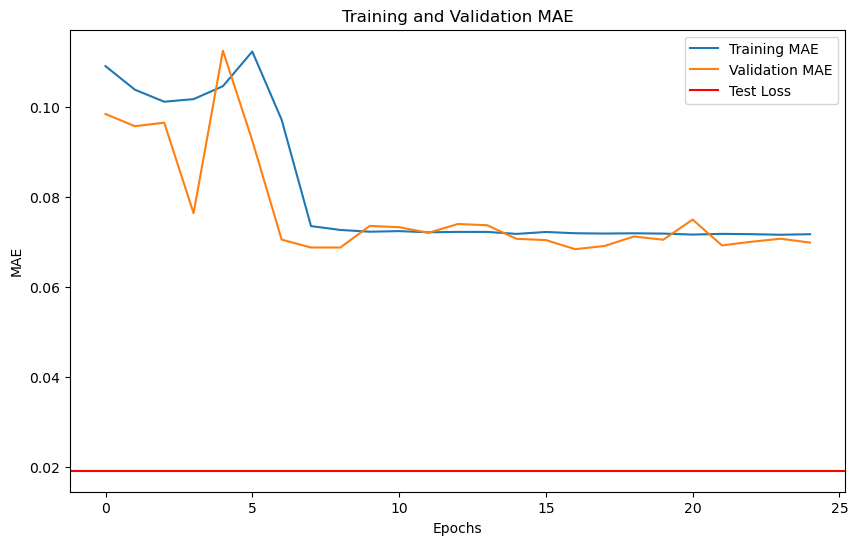

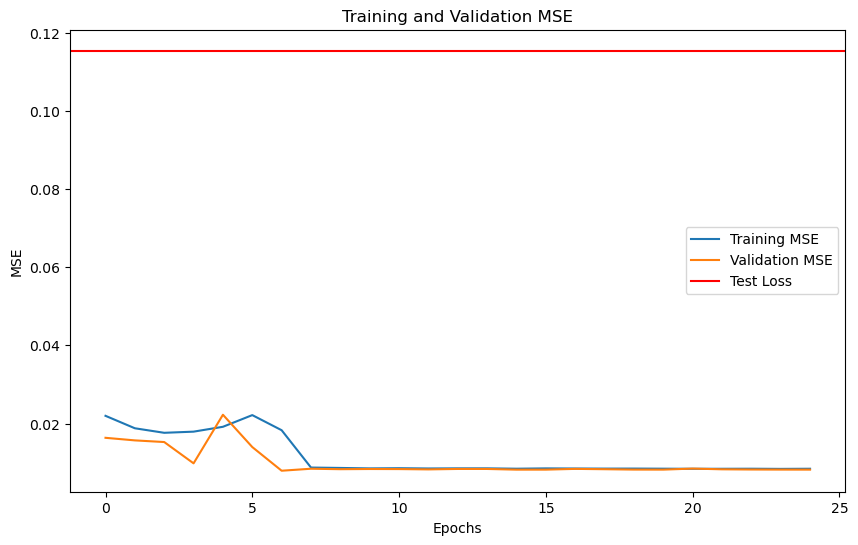

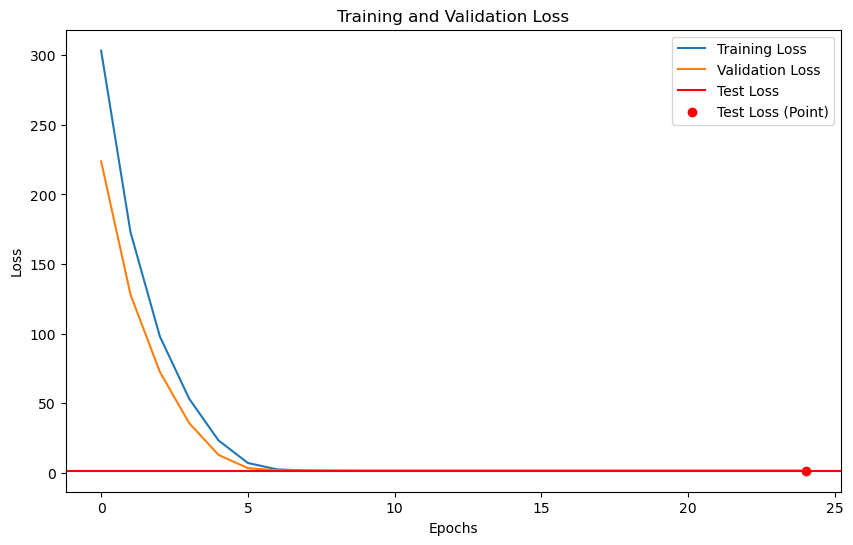

374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [86]:
X_batch4.fillna(SUBSTITUE_VALUE, inplace=True)
test_dataset_X1 = np.array(X_batch4).reshape(int(len(X_batch4)/TIMESTEPS), TIMESTEPS, features)
test_dataset_x2 = np.array(X2_batch4).reshape(X2_batch4.shape[0], 1, 10)
test_dataset_y = np.array(target_batch4)


test_dataset = tf.data.Dataset.from_tensor_slices(({'Input_1': test_dataset_X1, 'Input_2': test_dataset_x2}, test_dataset_y))
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_loss, test_mae, test_mse = ai_model.model.evaluate(test_dataset)
print("Evaluation Loss: ", test_loss,"Evaluation mae", test_mae,"Evaluation mse", test_mse)

plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.axhline(y=test_mae, color='r', linestyle='-', label='Test Loss')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plot the training and validation MSE
plt.figure(figsize=(10, 6))

plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.axhline(y=test_mse, color='r', linestyle='-', label='Test Loss')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='-', label='Test Loss')
plt.scatter(len(history.history['loss']) -1, test_loss, color='red', label= 'Test Loss (Point)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



unique_targets, counts = np.unique(target_batch4, axis=0, return_counts=True)

s1_test_dataset = tf.data.Dataset.from_tensor_slices((
    {'Input_1': test_dataset_X1[:counts[0]], 'Input_2': test_dataset_x2[:counts[0]]}))

s1_test_dataset = s1_test_dataset.batch(1)

s2_test_dataset = tf.data.Dataset.from_tensor_slices((
    {'Input_1': test_dataset_X1[counts[0]:], 'Input_2': test_dataset_x2[counts[0]:]}))

s2_test_dataset = s2_test_dataset.batch(1)

# Prefetch the dataset for optimal performance
s1_test_dataset = s1_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
s2_test_dataset = s2_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

s1_pred = ai_model.model.predict(s1_test_dataset)
s2_pred = ai_model.model.predict(s2_test_dataset)



In [83]:
s1_pred.mean(axis=0), s2_pred.mean(axis=0)

(array([[0.8364145 , 0.08061696, 0.08296829]], dtype=float32),
 array([[0.83614457, 0.08071592, 0.08313984]], dtype=float32))

In [84]:
ai_model.model.save("combined_model.keras")

In [85]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(ai_model.model, to_file='combined_model.keras', show_shapes=True, dpi=70)


AttributeError: module 'pydotplus' has no attribute 'PydotException'

In [ ]:
best_model = load_model("/combined_model.keras")
evaluation_results = best_model.evaluate(s1_test_dataset)

ValueError: File not found: filepath=/combined_model.keras. Please ensure the file is an accessible `.keras` zip file.